<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/Modeling_ICG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
!pip install autorch==0.3.2 > log.txt
import autorch
import random
torch.manual_seed(11)
np.random.seed(11)
random.seed(11)

In [2]:
def get_col(df,name):
  return df.columns[df.columns.str.contains(name)]

![img](https://i.imgur.com/hksoTrh.jpg)



# load data

In [4]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_c670.pkl')
c.keys(),c['x'],c['y'],len(c['x']),len(c['y'])

(dict_keys(['x', 'y']),
 ['Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr',
  'Simulation Case Conditions_Feed Rate_Feed from V615 Btm    NA_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from V615 Btm    Benzene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from V615 Btm    Toluene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr',
  'Simulation Case Conditions_Feed Rate_Feed from C820 Dist    NA_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from C820 Dist    Benzene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from C820 Dist    Toluene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr',
  'Simulation Case Conditions_Feed Rate_Feed from T651    NA_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from T651    Benzene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from T651    Toluene_wt%',
  'Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%',
  'Simulation Case Conditions_Spec 2 : NA in Ben

In [5]:
df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_c670.csv',index_col=0)
df.head()

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Simulation Case Conditions_C620 Distillate Rate_m3/hr
001-002,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,90.0,980.0,0.5
001-005,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,90.0,950.0,1.0
001-008,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,90.0,920.0,1.5
001-011,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,80.0,980.0,0.5
001-014,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,80.0,950.0,1.0


# Distillate Rate_m3/hr == 0.01的部份 改成 0

In [6]:
df.loc[df['Simulation Case Conditions_C620 Distillate Rate_m3/hr']==0.01,'Simulation Case Conditions_C620 Distillate Rate_m3/hr'] = 0

In [7]:
df[c['y']].max(),df[c['y']].min()

(Simulation Case Conditions_C620 Distillate Rate_m3/hr    10.25
 dtype: float64, Simulation Case Conditions_C620 Distillate Rate_m3/hr    0.0
 dtype: float64)

# modeling 不要限制輸出 可以有負值

  1%|▏         | 4/300 [00:00<01:10,  4.21it/s]

epoch:0 train_loss:0.3171 valid_loss:0.1746


 18%|█▊        | 54/300 [00:03<00:15, 16.30it/s]

epoch:50 train_loss:0.0044 valid_loss:0.0041


 35%|███▍      | 104/300 [00:05<00:10, 18.53it/s]

epoch:100 train_loss:0.0031 valid_loss:0.0028


 51%|█████▏    | 154/300 [00:08<00:08, 16.45it/s]

epoch:150 train_loss:0.0027 valid_loss:0.0030


 68%|██████▊   | 204/300 [00:11<00:05, 16.07it/s]

epoch:200 train_loss:0.0032 valid_loss:0.0031


 85%|████████▍ | 254/300 [00:14<00:02, 17.97it/s]

epoch:250 train_loss:0.0024 valid_loss:0.0040


100%|██████████| 300/300 [00:17<00:00, 17.57it/s]


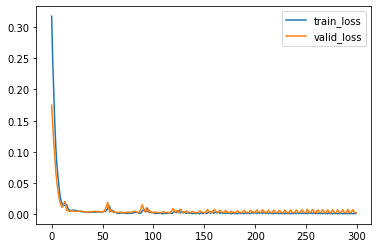

In [8]:
c620_icg = autorch.utils.PartBulider(df,c['x'],c['y'],limit_y_range=False)
c620_icg.train()

# evaluate

In [9]:
y_pred = c620_icg.predict(c620_icg.data['X_test'])
c620_icg.show_metrics(c620_icg.data['Y_test'],y_pred,e=0.02)

,R2,MSE,MAPE
Simulation Case Conditions_C620 Distillate Rate_m3/hr,0.992769,0.0121217,18.8559
AVG,0.992769,0.0121217,18.8559


# ICG while 迴圈

In [10]:
def ICG(Input):
  while True:
    output = c620_icg.predict(Input)
    # 如果大於0 結束迴圈
    if output['Simulation Case Conditions_C620 Distillate Rate_m3/hr'].values[0] > 0:
      return output,Input
    # 如果小於0 NA in Benzene_ppmw -= 30
    else:
      dist_rate = output['Simulation Case Conditions_C620 Distillate Rate_m3/hr'].values[0]
      na_in_benzene = Input['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw'].values[0]
      info = 'current Distillate Rate_m3/hr:{} NA in Benzene_ppmw:{} so NA in Benzene_ppmw -= 30'.format(dist_rate,na_in_benzene)
      print(info)
      Input['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw'] -= 30

In [11]:
print(df.shape)
df = df[df['Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%']==70.0]
df = df[df['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw']==980.0]
print(df.shape)

(1296, 15)
(122, 15)


In [12]:
Input = df[c['x']].sample(1)
Input

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw
029-020,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,77.0,0.212,35.413998,57.972996,70.0,980.0


In [13]:
output,Input = ICG(Input)

In [14]:
output

,Simulation Case Conditions_C620 Distillate Rate_m3/hr
029-020,0.000942


In [15]:
Input

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw
029-020,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,77.0,0.212,35.413998,57.972996,70.0,980.0


In [16]:
c620_icg.shrink()

In [17]:
joblib.dump(c620_icg,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_icg.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_icg.pkl']